In [1]:
%reset -f
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import lib.preprocess.envelope
import matplotlib.colors
import mne
import json
import retro_prepare_data

In [2]:
data_dir = 'datasets/RetrospectivePatients/id004_bj'
results_dir = 'results/exp10/exp10.33'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

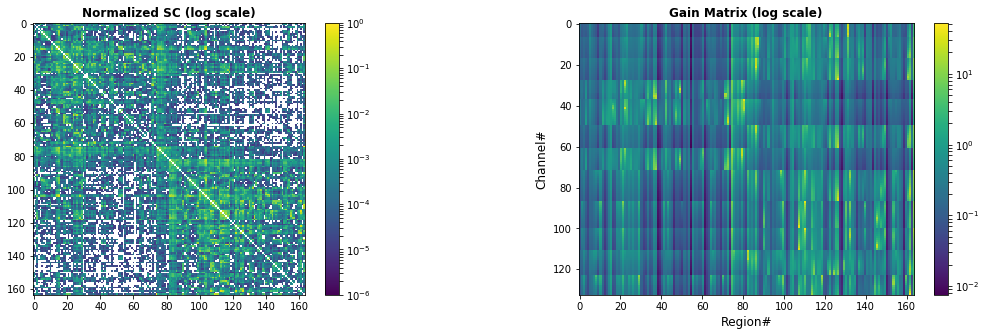

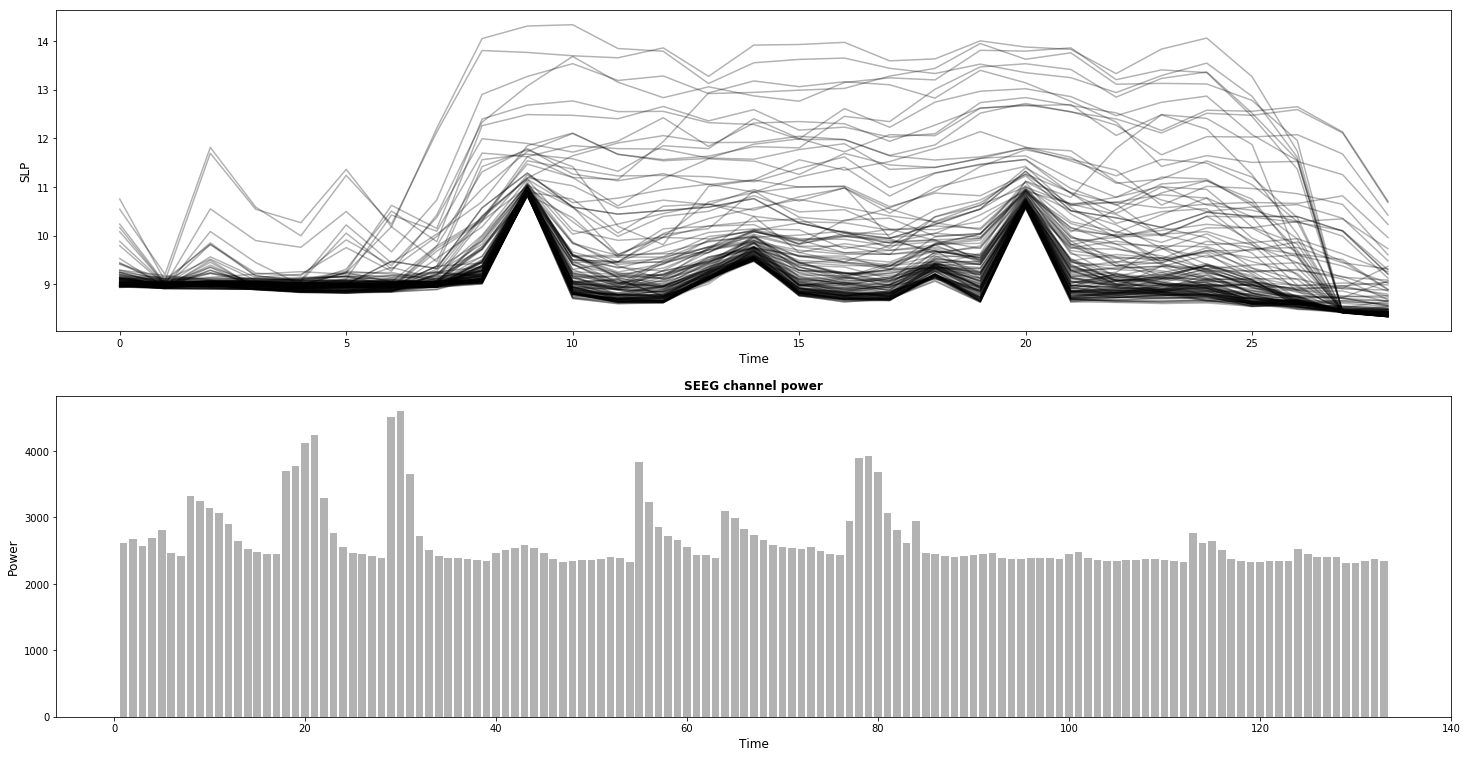

In [3]:
SC = np.loadtxt(f'{data_dir}/tvb/connectivity_des/weights.txt')
SC[np.diag_indices(SC.shape[0])] = 0
SC = SC/SC.max()

data = lib.io.stan.rload(f'{data_dir}/vep/data.R')
szr_onset_idxs = np.where(data['is_first'] == 1)[0]
slp = data['seeg'][:,szr_onset_idxs[1]:szr_onset_idxs[2]].T
gain = data['gain']

# szr_onset_idxs = np.where(data['is_first'] ==1)[0]
# seeg = data['seeg'][:,szr_onset_idxs[0]:szr_onset_idxs[1]].T
# slp = lib.preprocess.envelope.bfilt(seeg, 256, 0.5, 'highpass', axis=0)
# slp = lib.preprocess.envelope.bfilt(slp, 256, 20, 'lowpass', axis=0)


# with open(f'{data_dir}/seeg/fif/BTcrise1appportable_0006.json') as fd:
#     meta_data = json.load(fd)
# bad_channels = meta_data['bad_channels']
# exclude = meta_data['bad_channels'] + meta_data['non_seeg_channels']
# raw = mne.io.Raw(f'{data_dir}/seeg/fif/BTcrise1appportable_0006.raw.fif', verbose='WARNING')
# picks = set(raw.ch_names) - set(exclude)
# assert meta_data['onset'] is not None and meta_data['termination'] is not None
# raw.crop(tmin=meta_data['onset'], tmax=meta_data['termination'])
# raw.load_data()
# raw.pick_channels(picks)
# seeg = raw.get_data().T[0:-1:8,:]

# slp = lib.preprocess.envelope.bfilt(seeg, 64, 5.0, 'highpass', axis=0)
# slp = np.log(lib.preprocess.envelope.mov_avg(slp**2, 20))[0:-65,:]
# slp = lib.preprocess.envelope.bfilt(slp, 64, 0.05, 'lowpass', axis=0)
# slp = slp[0:-1:64,:][0:180,:] # Downsample the data and truncate at seizure offset
snsr_pwr = np.sum(slp**2, axis=0)

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(SC,norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=SC.max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

plt.subplot(122)
plt.imshow(gain,norm=matplotlib.colors.LogNorm(vmin=gain.min(), vmax=gain.max()));
plt.colorbar(fraction=0.046,pad=0.04);
plt.xlabel('Region#', fontsize=12)
plt.ylabel('Channel#', fontsize=12)
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(slp, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],snsr_pwr, color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
plt.savefig(f'{results_dir}/figures/fitting_target.png')
# plt.tight_layout()


In [5]:
nn = data['nn']
ns = data['ns']
nt = slp.shape[0]
I1 = 3.1
dtt = 0.1
# tau0=30
# time_step=0.1

stan_fname = 'vep-snsrfit-ode-hpinfer'

x0_star = np.zeros(nn)
x_init_star = np.zeros(nn)
z_init_star = np.zeros(nn)
amplitude_star = 0.0
offset = 0.0
time_step_star = 0.0
K_star = 0.0
tau0_star = 0.0
epsilon_slp_star = 0.0
epsilon_snsr_pwr_star = 0.0

param_init = {'x0_star':x0_star, 'x_init_star':x_init_star, 'z_init_star':z_init_star,
              'amplitude_star':amplitude_star, 'offset':offset, 'time_step_star':time_step_star,
              'K_star':K_star, 'tau0_star':tau0_star,
              'epsilon_slp_star':epsilon_slp_star,
              'epsilon_snsr_pwr_star':epsilon_snsr_pwr_star}
param_init_file = 'param_init.R'
os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/param_init.R',param_init)

# epsilon_snsr_pwr = 700
for epsilon_slp in np.array([1.0]):
    fname_suffix = f'hyper_infer'
    data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'dtt':dtt, 'SC':SC, 'gain': gain,
            'slp':slp, 'snsr_pwr':snsr_pwr}
#             'epsilon_slp':epsilon_slp, 'epsilon_snsr_pwr':epsilon_snsr_pwr}
    input_Rfile = f'fit_data_snsrfit_ode_{fname_suffix}.R'
    os.makedirs(f'{results_dir}/Rfiles',exist_ok=True)
    lib.io.stan.rdump(f'{results_dir}/Rfiles/{input_Rfile}',data)

In [6]:
%%bash -s "$stan_fname"
stancompile.sh $1

/home/anirudh/Academia/projects/vep.stan

--- Translating Stan model to C++ code ---
bin/stanc  /home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-hpinfer.stan --o=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-hpinfer.hpp
Model name=vep_snsrfit_ode_hpinfer_model
Input file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-hpinfer.stan
Output file=/home/anirudh/Academia/projects/vep.stan/vep-snsrfit-ode-hpinfer.hpp

--- Linking C++ model ---
g++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /home/anirudh/Academia/projec

DIAGNOSTIC(S) FROM PARSER:



In [7]:
%%bash -s "$stan_fname" "$results_dir" "$input_Rfile" "$fname_suffix"

STAN_FNAME=$1
RESULTS_DIR=$2
INPUT_RFILE=$3
FNAME_SUFFIX=$4
for i in {1..1};
do
./${STAN_FNAME} id=$((100*${i})) sample num_samples=200 num_warmup=200 \
save_warmup=1 adapt delta=0.8 algorithm=hmc engine=nuts max_depth=10 \
data file=${RESULTS_DIR}/Rfiles/${INPUT_RFILE} \
init=${RESULTS_DIR}/Rfiles/param_init.R random seed=$((987*${i})) \
output file=${RESULTS_DIR}/samples_${FNAME_SUFFIX}_chain${i}.csv refresh=10 \
&> ${RESULTS_DIR}/logs/snsrfit_ode_${FNAME_SUFFIX}_chain${i}.log &
done

In [9]:
# import lib.io.stan
# import importlib
# importlib.reload(lib.io.stan)

# csv_fname = 'results/exp10/exp10.4/samples_epsinfer_chain1.csv'
# nwarmup = 200
# nsampling = 100
# ignore_warmup = True
# variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
#                          'divergent__', 'energy__','x0',  'x', 'mu_seeg', 'amplitude', 'offset',\
#                          'x_init', 'z_init', 'epsilon']
# pstr_samples_1 = lib.io.stan.read_samples(csv_fname) # read sampler diagnostics and x0 for all sampling iterations
pstr_samples_1 = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{i}.csv' for i in [1]]) # read sampler diagnostics and x0 for all sampling iterations

# csv_fname = 'results/exp10/exp10.4/samples_eps0.1_chain1.csv'
# nwarmup = 1000
# nsampling = 1000
# ignore_warmup = True
# variables_of_interest = ['x','z']
# pstr_samples_2 = lib.io.stan.read_samples(csv_fname,nwarmup,nsampling,ignore_warmup,variables_of_interest) # read 10 samples of hidden state variables x and z

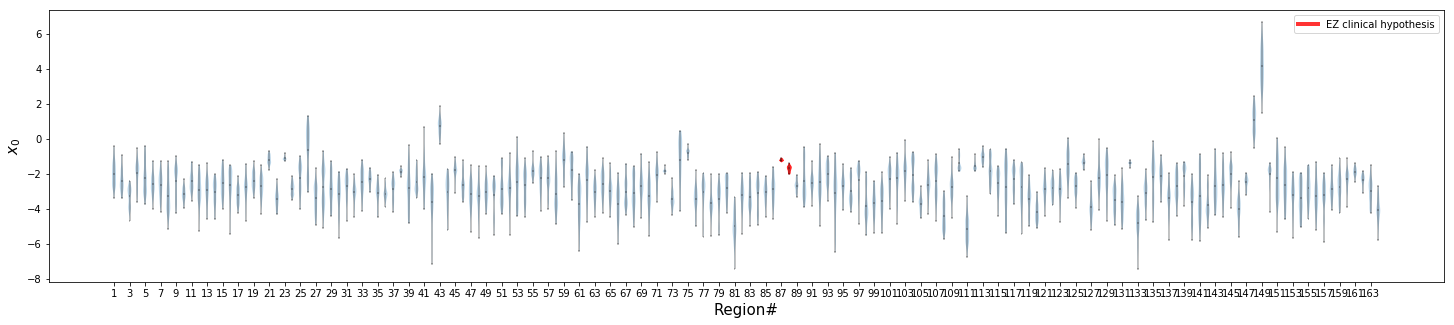

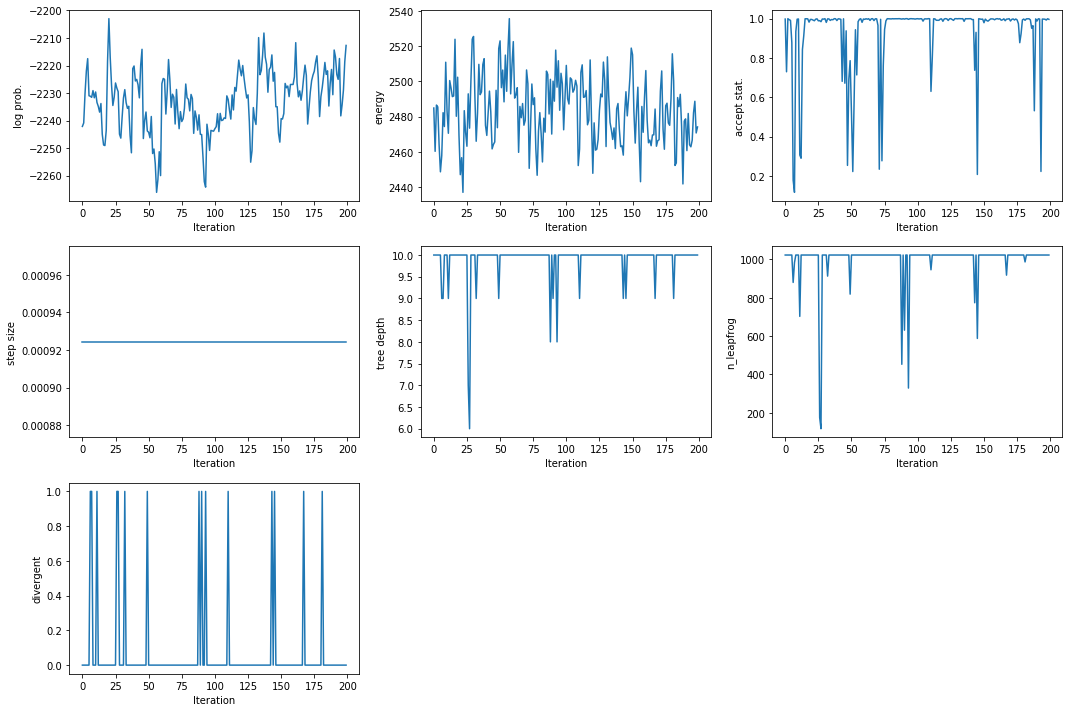

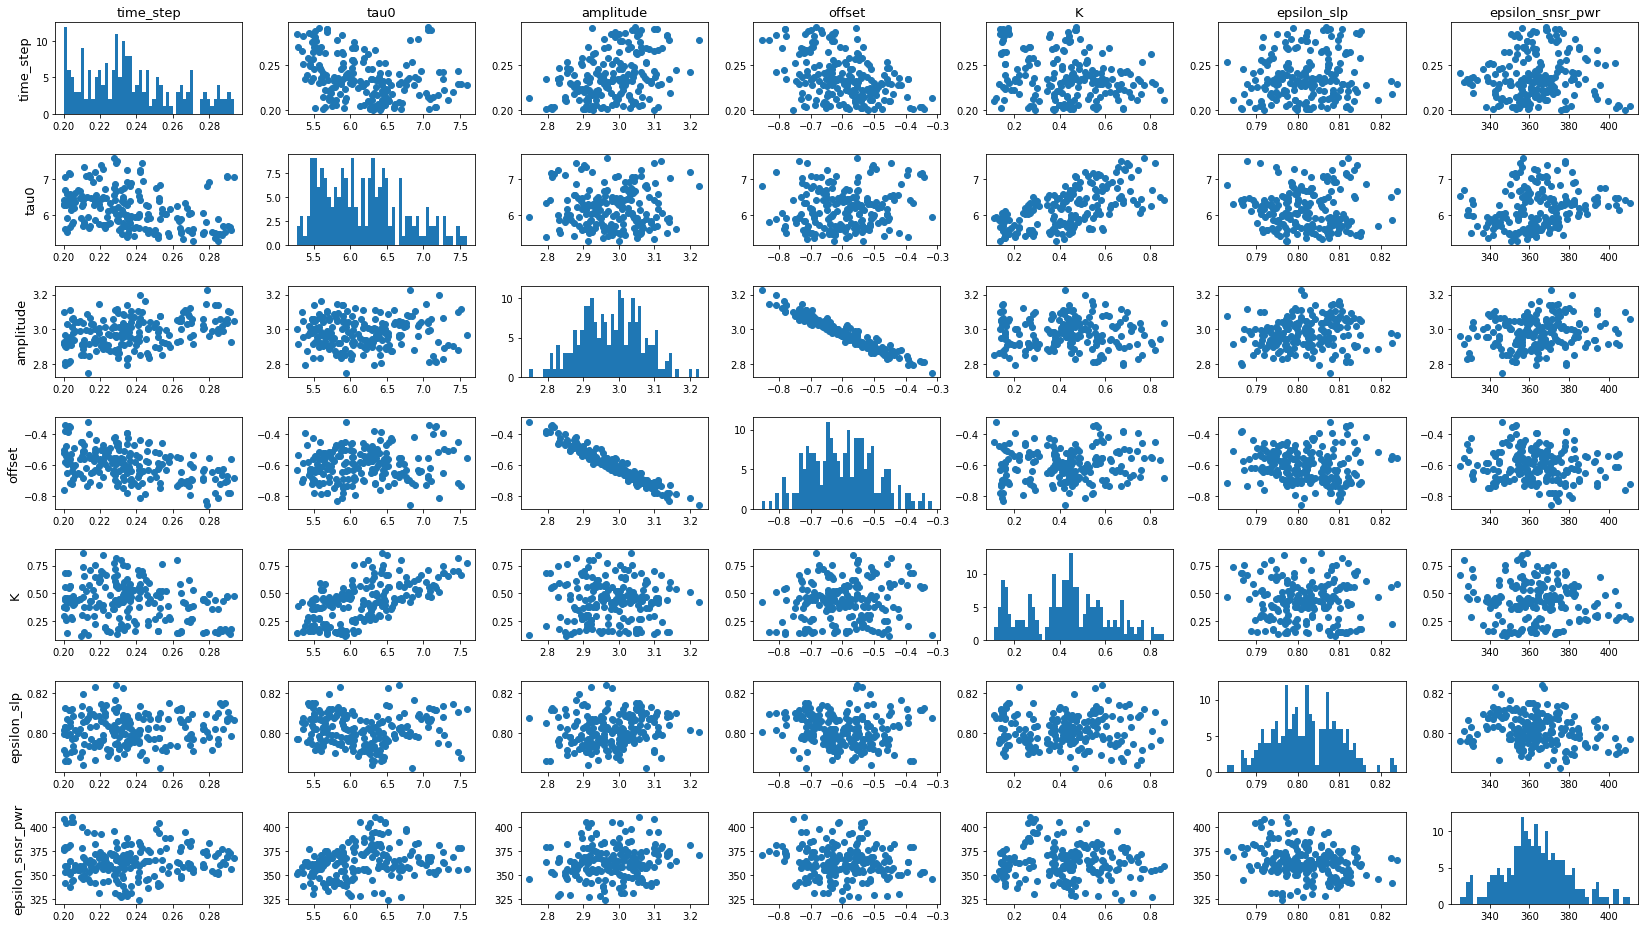

In [11]:
import importlib
importlib.reload(lib.plots.stan)

ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0] + 1

lib.plots.stan.x0_violin_patient(pstr_samples_1['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
# plt.figure(figsize=(25,5))
# plt.violinplot(pstr_samples_1['x0'], showmeans=True, points=1000);
# plt.title('Distribution of inferred x0', fontsize=13, fontweight='bold')
# plt.xticks(np.r_[1:nn+1:2], np.r_[1:nn+1:2])
# plt.xlabel('Region#')

lib.plots.stan.nuts_diagnostics(pstr_samples_1, figsize=(15,10), figname=f'{results_dir}/figures/nuts_diagnostics_{fname_suffix}.png')

plt.figure(figsize=(23,13))
params = ['time_step', 'tau0', 'amplitude', 'offset', 'K', 'epsilon_slp', 'epsilon_snsr_pwr']
nParams = len(params)
for i in range(nParams):
    for j in range(nParams):
        plt.subplot(nParams, nParams, i * nParams + (j + 1))
        if(i == j):
            plt.hist(pstr_samples_1[params[i]].flatten(), bins=50)
        else:
            xvals = np.mean(pstr_samples_1[params[j]], axis=1) if len(pstr_samples_1[params[j]].shape)>1 else pstr_samples_1[params[j]]
            yvals = np.mean(pstr_samples_1[params[i]], axis=1) if len(pstr_samples_1[params[i]].shape)>1 else pstr_samples_1[params[i]]
            plt.plot(xvals, yvals, 'o')
        if(i == 0):
            plt.title(params[j], fontsize=13)
        if(j == 0):
            plt.ylabel(params[i], fontsize=13, rotation=90)
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/params_pair_plots_{fname_suffix}.png')

# # Mean and 2*std of source activity(x) estimated from posterior samples
# plt.figure(figsize=(15,20))
# x_mean = np.mean(pstr_samples_1['x'], axis = 0)
# x_std = np.std(pstr_samples_1['x'], axis = 0)
# nt = x_mean.shape[0]
# nn = x_mean.shape[1]
# for i in range(nn):
#     plt.plot(x_mean[:,i]+4*i)
#     plt.fill_between(np.r_[0:nt], x_mean[:,i] - 2*x_std[:,i] + 4*i, x_mean[:,i] + 2*x_std[:,i] + 4*i,alpha=0.1)
# plt.title('source activity(x)',fontsize=15);
# plt.xlabel('time',fontsize=15);
# plt.ylabel('Region#',fontsize=15);
# plt.yticks(np.mean(x_mean,axis=0) + 4*np.r_[0:nn], np.r_[1:nn+1]);

In [ ]:
# plt.subplot(121)
# plt.plot(pstr_samples_1['epsilon_slp'])
# plt.subplot(122)
plt.plot(pstr_samples_1['epsilon_snsr_pwr'])
plt.figure()
plt.plot(np.log(pstr_samples_1['stepsize__'][:]))

Posterior Predicted source activity

In [ ]:
pstr_samples_1['x0'][:,86]

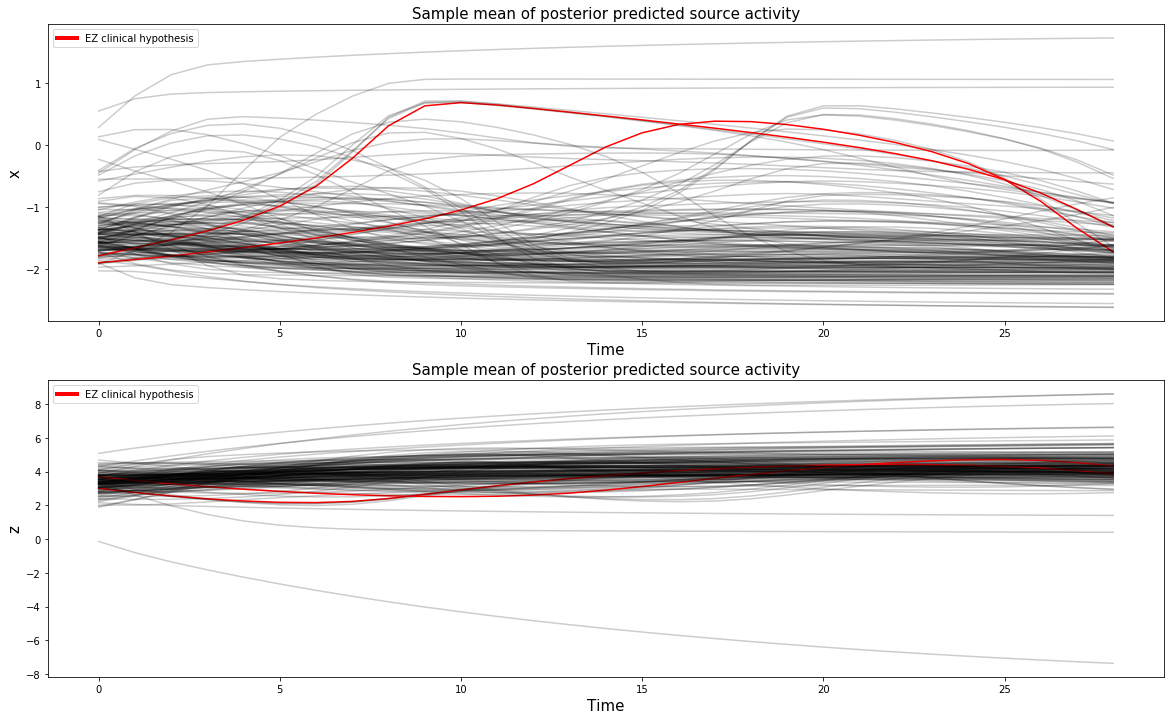

In [12]:
x_pp_mean = np.mean(pstr_samples_1['x'], axis=0)
z_pp_mean = np.mean(pstr_samples_1['z'], axis=0)


plt.figure(figsize=(20,12))
plt.subplot(211)
legend_elements = [Line2D([0], [0], color='red', linewidth=4, label='EZ clinical hypothesis')]
for i in range(nn):
    if(i+1 in ez_hyp):
        plt.plot(x_pp_mean[:,i], color='red');
    else:
        plt.plot(x_pp_mean[:,i], color='black', alpha=0.2);
plt.xlabel('Time', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title('Sample mean of posterior predicted source activity', fontsize=15)
plt.legend(handles=legend_elements)

plt.subplot(212)
for i in range(nn):
    if(i+1 in ez_hyp):
        plt.plot(z_pp_mean[:,i], color='red');
    else:
        plt.plot(z_pp_mean[:,i], color='black', alpha=0.2);
plt.xlabel('Time', fontsize=15)
plt.ylabel('z', fontsize=15)
plt.title('Sample mean of posterior predicted source activity', fontsize=15)
plt.legend(handles=legend_elements)

plt.savefig(f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')

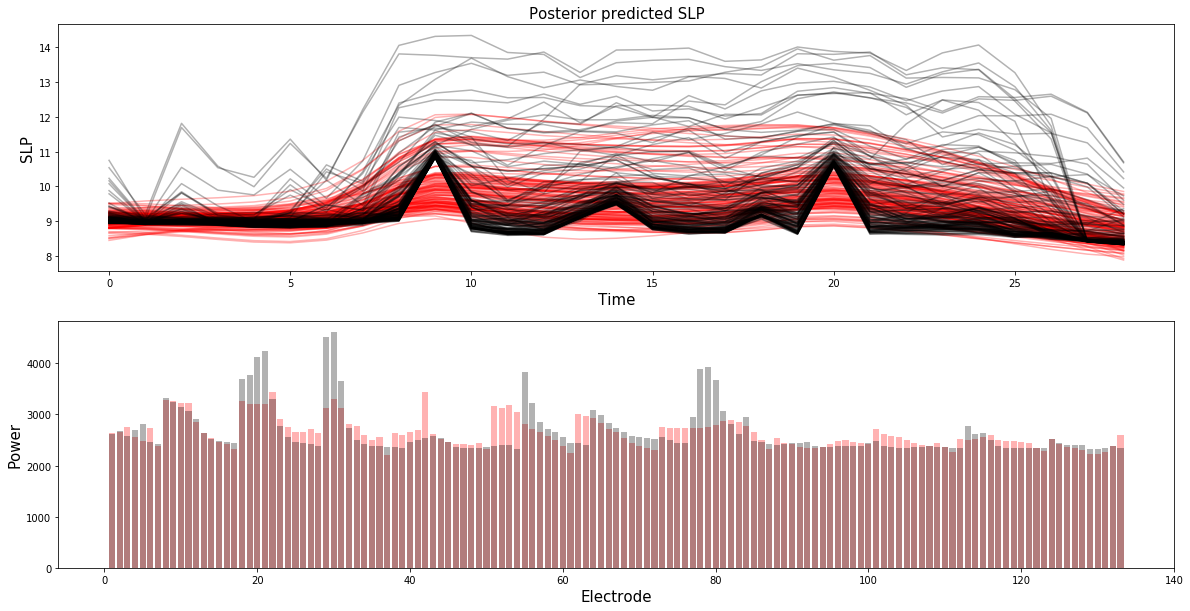

In [13]:
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
slp = pstr_samples_1['mu_slp'].mean(axis=0)
snsr_pwr = pstr_samples_1['mu_snsr_pwr'].mean(axis=0)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(slp, color='red', alpha=0.3);
plt.plot(fit_data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.ylabel('SLP', fontsize=15)
plt.title('Posterior predicted SLP', fontsize=15)

plt.subplot(212)
plt.bar(np.arange(1,ns+1), snsr_pwr, color='red', alpha=0.3);
plt.bar(np.arange(1,ns+1), fit_data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/posterior_predicte_slp_{fname_suffix}.png')

